## Import required packages 

In [35]:
import pandas as pd
import numpy as np
import matplotlib.pyplot as plt
import seaborn as sns
import statsmodels.api as sm
from statsmodels.tsa.arima_model import ARIMA, ARMA
from matplotlib.pylab import rcParams
from statsmodels.graphics.tsaplots import plot_pacf, plot_acf
from matplotlib.pylab import rcParams
from statsmodels.tsa.seasonal import seasonal_decompose
from sklearn.metrics import mean_squared_error

## Import data from AWS and prepare for processing

In [2]:
df = pd.read_csv('https://mod4finalproject.s3.amazonaws.com/zillow_cleaned_no_nulls.csv',
                   index_col=0,
                   dtype = {'zip':'object'})

In [3]:
df.index = pd.to_datetime(df.index)

In [4]:
df.columns

Index(['regionid', 'zip', 'city', 'state', 'metro', 'countyname', 'sizerank',
       'value'],
      dtype='object')

In [5]:
df = df.drop(columns = ['regionid', 'city', 'state', 'metro', 'countyname', 'sizerank'])

In [6]:
d2011 = '2011-05-01'
d2018 = '2018-04-01'

In [7]:
df = df[d2011:d2018]

## Define top 5 zip codes

In [8]:
top_zips = ['33976', '33974', '47353', '71263', '67860']

In [9]:
df = df.loc[df.zip.isin(top_zips)]

## Define functions for use in analysis

In [10]:
def plot_zip(df,zipcode, start, end):
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    sns.lineplot(x=zip_df.index, y=zip_df.value)
    return plt.show()

In [11]:
def plot_diff(df, zipcode, start, end, lag):
    zip_df = df.loc[df['zip'] == zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)] 
    zip_df['diff'] = zip_df.value - zip_df.value.shift(lag)
    sns.set(rc={'figure.figsize':(15,5)}, style='darkgrid')
    plot = sns.lineplot(x=zip_df.index, y=zip_df['diff'])
    return plt.show()

In [12]:
def get_zip_df(df, zipcode, start, end):
    zip_df = df.loc[df['zip']==zipcode]
    zip_df = zip_df.loc[(zip_df.index >= start) & (zip_df.index <= end)]
    return zip_df

In [13]:
def get_diff_df(df, zipcode, start, end, lag):
    diff_df = df.loc[df['zip'] == zipcode]
    diff_df = diff_df.loc[(diff_df.index >= start) & (diff_df.index <= end)] 
    diff_df['diff'] = diff_df.value - diff_df.value.shift(lag)
    diff_df = diff_df.dropna(axis=0)
    return diff_df

In [14]:
## Test functions
# diff_df(df, top_zips[0], d2011, d2018, 2)

In [15]:
## Test functions
# for z in top_zips:
#     diff_plot(df, z, d2011, d2018, 1)

## Analysis for Terry, LA 71263

In [16]:
zipcode = '71263'
start = d2011
end = d2018
lag = 1

lehigh = get_zip_df(df, zipcode, start, end)

### Plot of values, monthly

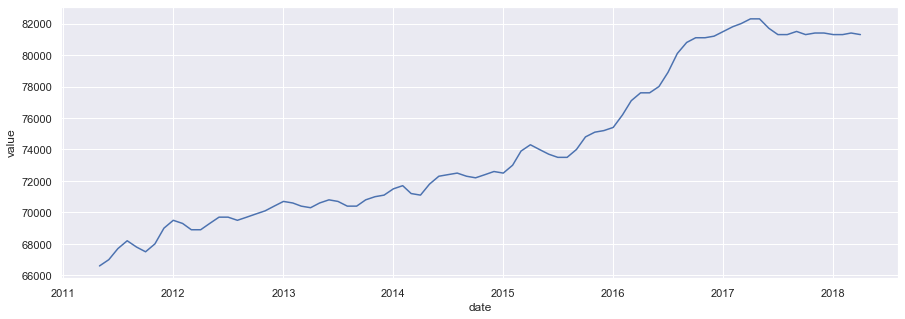

In [17]:
plot_zip(df, zipcode, start, end)

### Decomposition

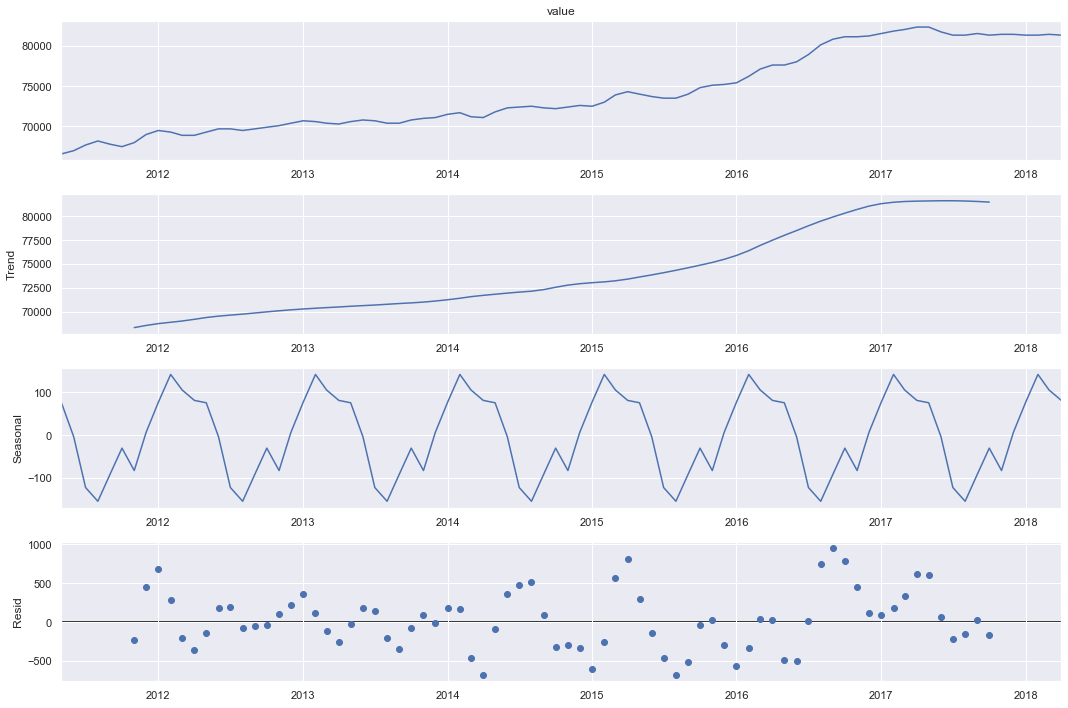

In [18]:
rcParams['figure.figsize'] = (15, 10)
result = seasonal_decompose(lehigh.value, model='additive')
result.plot()
plt.show()

### Plot of difference from lag

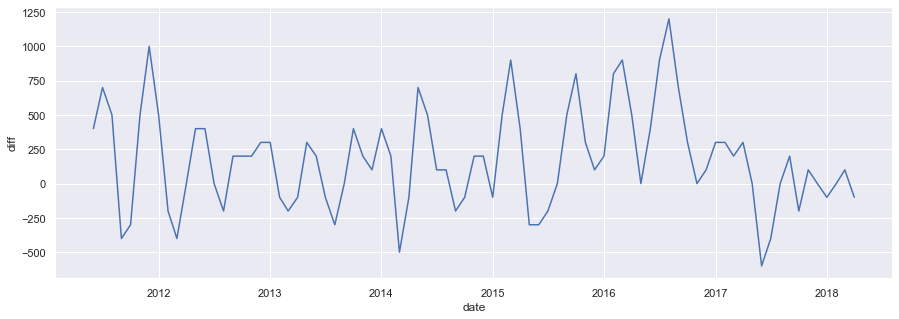

In [19]:
plot_diff(df, zipcode, start, end, lag)

### ACF and PACF for lag values

In [20]:
diff_df = get_diff_df(df, zipcode, start, end, lag)

### ACF (Pandas)

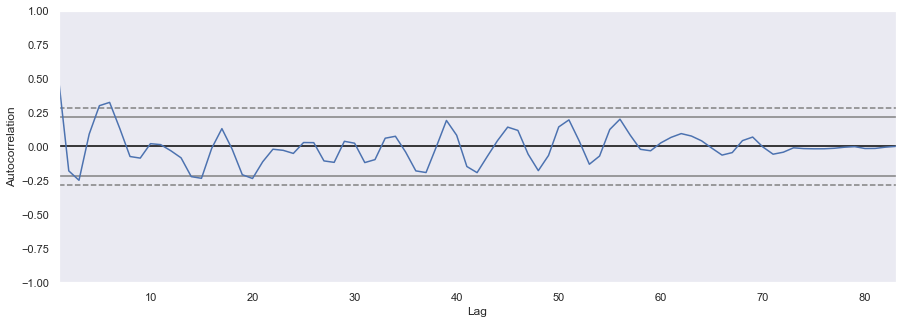

In [21]:
plt.figure(figsize=(15,5))
pd.plotting.autocorrelation_plot(diff_df['diff']);

### ACF (statsmodel)

In [22]:
# diff_df['diff']

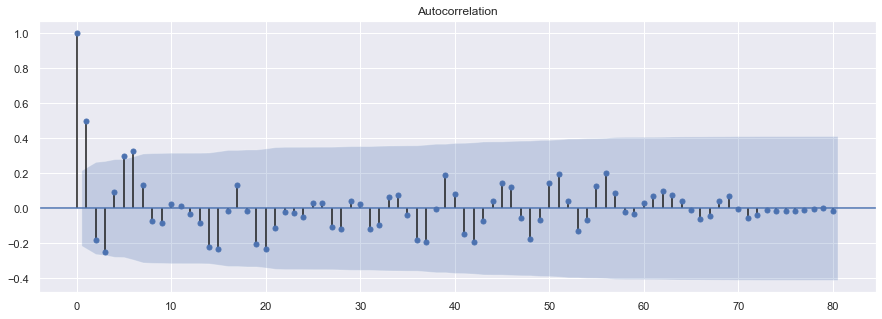

In [23]:
rcParams['figure.figsize'] = 15, 5
plot_acf(diff_df['diff'], lags=80);

### PACF (statsmodel)

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


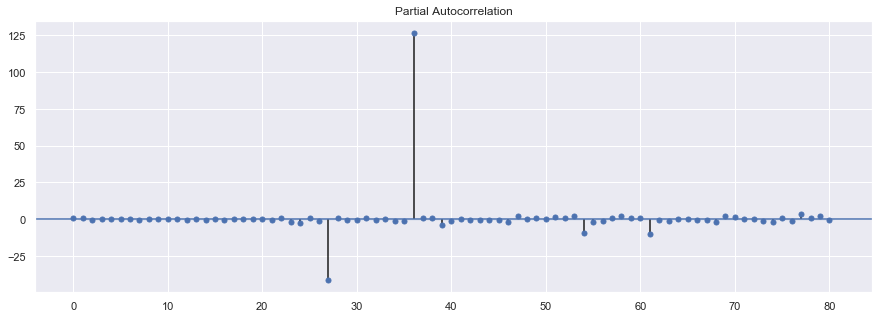

In [24]:
rcParams['figure.figsize'] = 15, 5
plot_pacf(diff_df['diff'], lags=80);

In [25]:
import pickle
pickle_in = open('../data/processed/train_val_test.pickle', 'rb')
train_val_test = pickle.load(pickle_in)

train = train_val_test[0]
val = train_val_test[1]
test = train_val_test[2]

In [26]:
train = train.loc[train.zip == zipcode]
val = val.loc[val.zip == zipcode]
test = test.loc[test.zip == zipcode]

In [27]:
model = ARIMA(np.asarray(train.value), order=(1,1,0))
model_fit = model.fit(disp=0)
model_fit.summary()

<class 'statsmodels.iolib.summary.Summary'>
"""
                             ARIMA Model Results                              
==============================================================================
Dep. Variable:                    D.y   No. Observations:                   59
Model:                 ARIMA(1, 1, 0)   Log Likelihood                -424.481
Method:                       css-mle   S.D. of innovations            321.808
Date:                Thu, 07 May 2020   AIC                            854.962
Time:                        02:58:53   BIC                            861.194
Sample:                             1   HQIC                           857.395
                                                                              
==============================================================================
                 coef    std err          z      P>|z|      [0.025      0.975]
------------------------------------------------------------------------------
const        192.9131     72.170      2.673      0.008      51.462     334.364
ar.L1.D.y      0.4262      0.117      3.632      0.000       0.196       0.656
                                    Roots                                    
=============================================================================
                  Real          Imaginary           Modulus         Frequency
-----------------------------------------------------------------------------
AR.1            2.3466           +0.0000j            2.3466            0.0000
-----------------------------------------------------------------------------
"""

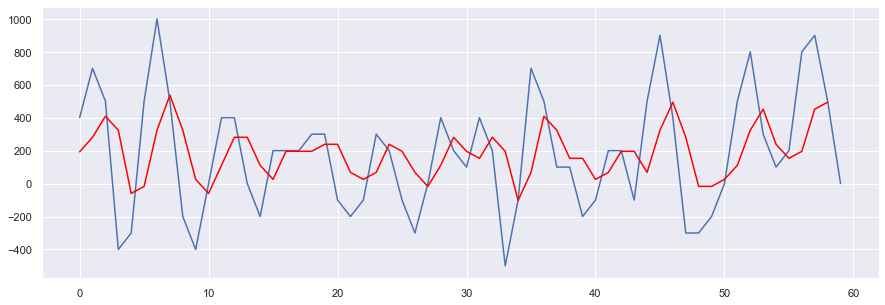

In [34]:
plt.plot(np.array(diff_df['diff'])[0:60])
plt.plot(model_fit.fittedvalues, color='red')
plt.show()

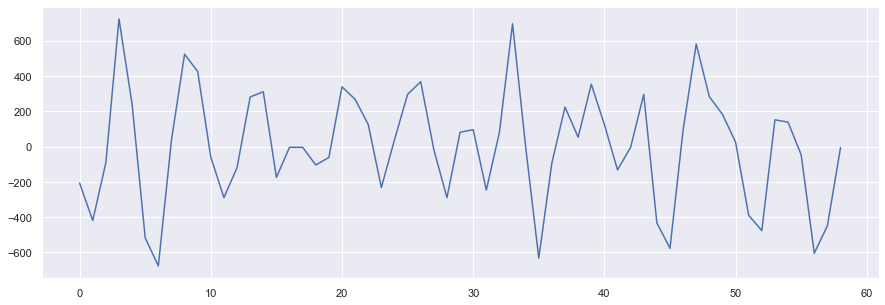

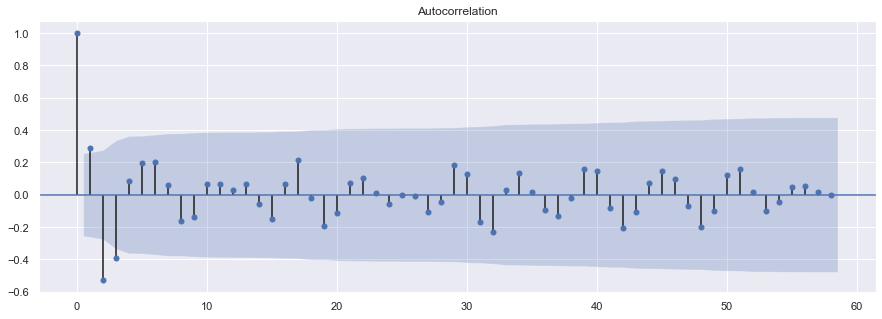

/opt/anaconda3/lib/python3.7/site-packages/statsmodels/regression/linear_model.py:1406: RuntimeWarning: invalid value encountered in sqrt
  return rho, np.sqrt(sigmasq)


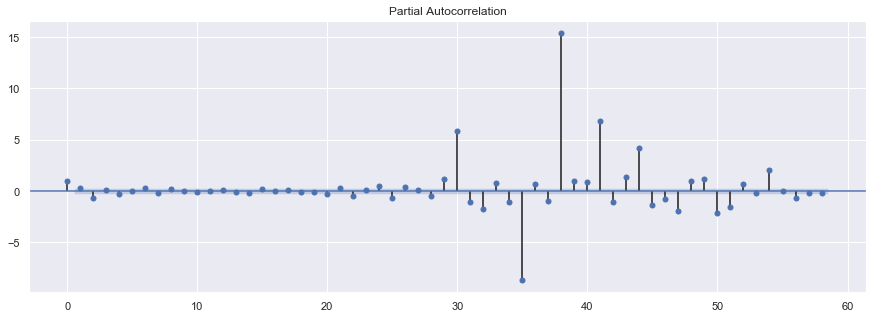

In [28]:
resid = model_fit.fittedvalues - np.array(diff_df['diff'])[0:59]
plt.plot(resid)
plt.show()
rcParams['figure.figsize'] = 15, 5
plot_acf(resid, lags=58)
plt.show()
plot_pacf(resid, lags=58)
plt.show()

In [29]:
pred = model_fit.forecast(steps=24)
val_pred = pred[0][:12]
test_pred = pred[0][11:-1]

RMSE for Validation Period: 1707.9087405594846


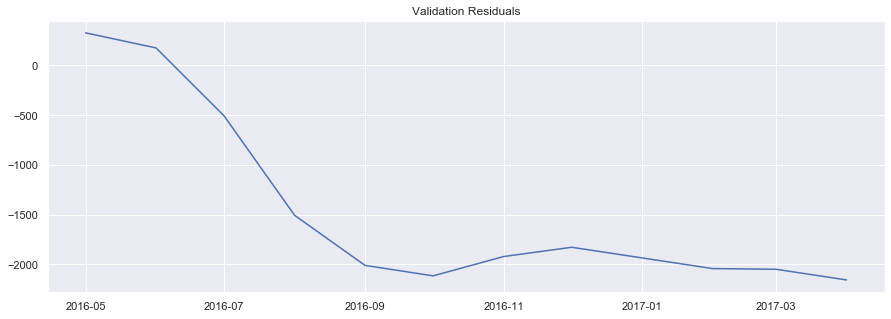

In [36]:
val_resid = val_pred - val.value
rmse = np.sqrt(mean_squared_error(val.value, val_pred))
print('RMSE for Validation Period: {}'.format(rmse))
plt.plot(val_resid)
plt.title('Validation Residuals')
plt.show()

RMSE for Test Period: 899.470734561511


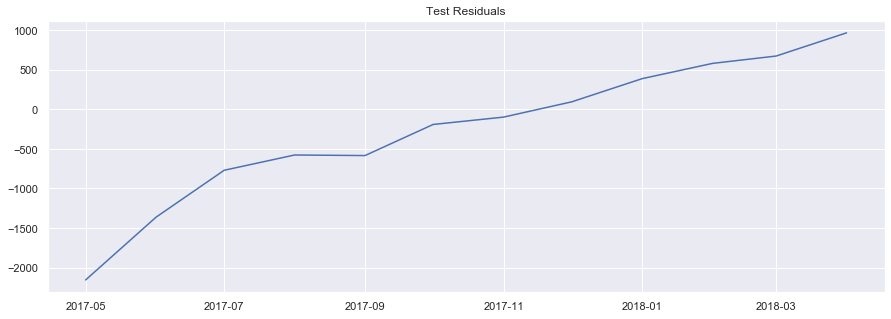

In [39]:
test_resid = test_pred - test.value
rmse = np.sqrt(mean_squared_error(test.value, test_pred))
print('RMSE for Test Period: {}'.format(rmse))
plt.plot(test_resid)
plt.title('Test Residuals')
plt.show()

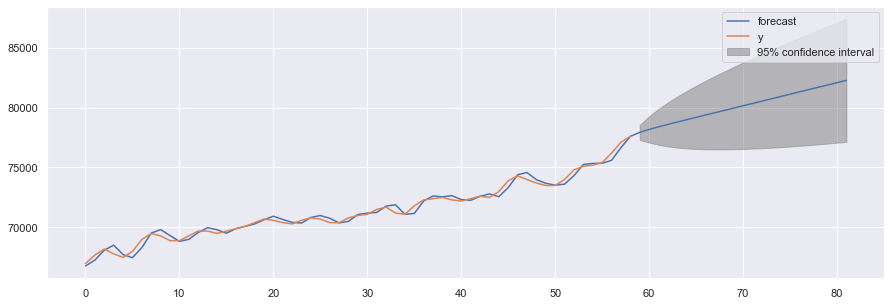

In [40]:
model_fit.plot_predict(1,82)
plt.show()

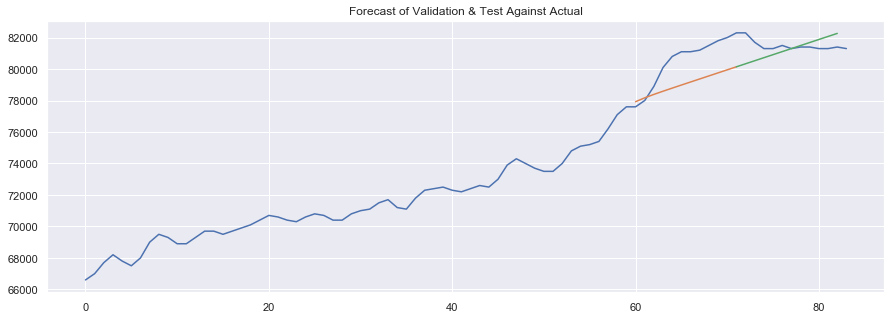

In [42]:
nan = np.full((60,1),np.nan)
nan1 = np.full((71,1),np.nan)
plt.plot(np.array(lehigh.drop('zip',axis=1)))
plt.plot(np.append(nan, val_pred))
plt.plot(np.append(nan1, test_pred))
plt.title('Forecast of Validation & Test Against Actual')
plt.show()